In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Bidirectional, Add, LSTM, Flatten, Dropout
from tensorflow import keras
import tensorflow as tf



2023-05-12 14:45:26.503821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('2249345v4423910.csv', index_col=0)
df

,ltp odds,r1 spread,r1 pup,r2 spread,r2 pup,enhanced_markov,markov_odds,r1_0,r1_1,r1_2,r1_3,r2_0,r2_1,r2_2,r2_3
2018-07-07 10:36:10,0.424641,0.093909,0.409607,0.019749,0.484152,0.883068,0.423074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-07 10:36:15,0.424423,0.093909,0.409607,0.019749,0.484152,0.883068,0.423074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-07 10:36:20,0.424206,0.093909,0.409607,0.019749,0.484152,0.883068,0.423074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-07 10:36:25,0.423989,0.093909,0.409607,0.019749,0.484152,0.883068,0.423074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-07 10:36:30,0.423772,0.093909,0.409607,0.019749,0.484152,0.883068,0.423074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-07 13:42:02,1.000000,0.008965,0.737546,0.594928,0.384681,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-07 13:42:05,1.000000,0.008965,0.737546,0.594928,0.384681,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-07 13:42:07,1.000000,0.008965,0.737546,0.594928,0.384681,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-07 13:42:10,1.000000,0.008965,0.737546,0.594928,0.384681,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
data = df.to_numpy()
data

array([[0.4246405 , 0.09390895, 0.40960749, ..., 0.        , 0.        ,
        1.        ],
       [0.42442341, 0.09390895, 0.40960749, ..., 0.        , 0.        ,
        1.        ],
       [0.42420631, 0.09390895, 0.40960749, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.00896503, 0.73754648, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.00896503, 0.73754648, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.00896503, 0.73754648, ..., 0.        , 1.        ,
        0.        ]])

In [4]:
train_temp, test = train_test_split(data, test_size=0.8, shuffle=False)
train, val = train_test_split(train_temp, test_size=0.2, shuffle=False)
# train_x, train_y = seq2seq_model.truncate_data(data, 60 * 3, 60)
# train = data[: 60 * 8, :]
# test = data[60 * 8 :, :]
print(test.shape, train.shape)
# print(train_x[2,:,0])
# print(train_y[2,:,0])

(1845, 15) (368, 15)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 75, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 75, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_10 (Dense)            (None, 16)                1616      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 72,433
Trainable params: 72,433
Non-trainable params: 0
_________________________________________________________________


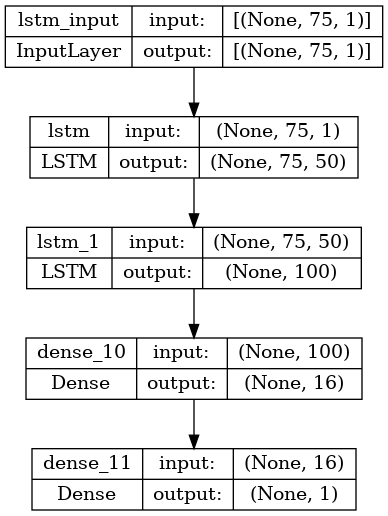

In [6]:
model = load_model("transfer_lstm_model")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

In [22]:
# score, scores, actual, predicted = seq2seq_model.evaluate_model(model, train, test, 3, 36, features_out=range(1), features=range(1), features_in_num=1, features_out_num=1, initial_epochs=100, epochs=2, batches_to_train=100000)
window = 75
val_x, val_y = seq2seq_model.truncate_single_step(train, window, features_in=range(1), features_out=range(1))
results = model.evaluate(val_x, val_y)
preds = model.predict(val_x)

10/10 [==============================] - 0s 3ms/step


RMSE:  0.3330046242480201
MAE:  0.26727429032325745


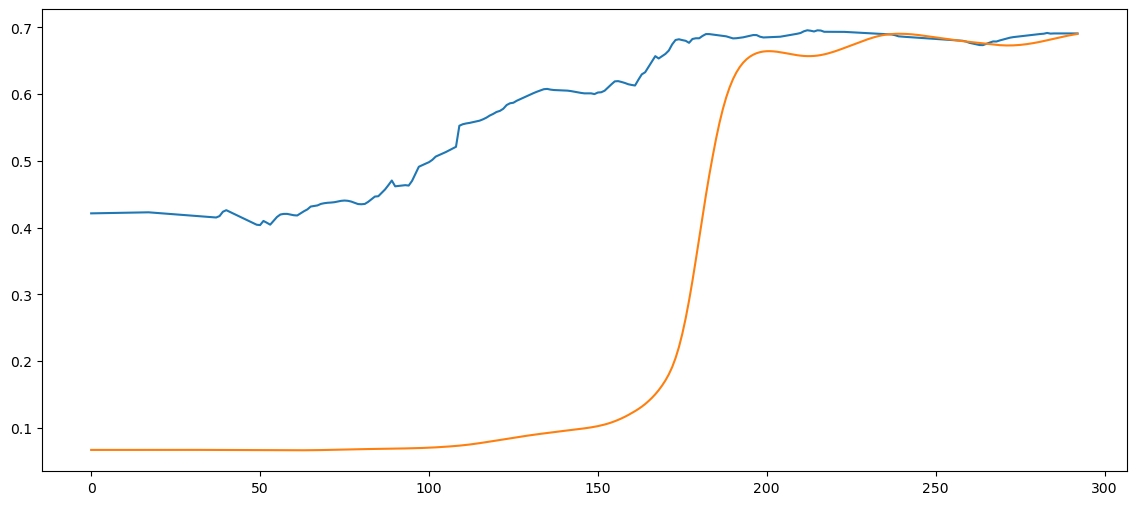

In [23]:
plt.figure(figsize=(14,6))
plt.plot(val_y[:,0])
plt.plot(preds[:,0])
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [24]:
train_x, train_y = seq2seq_model.truncate_single_step(train_temp, n_steps=window, features_in=range(1), features_out=range(1))
val_x, val_y = seq2seq_model.truncate_single_step(val, window, features_in=range(1), features_out=range(1))
features_out_num = train_y.shape[1]
print(val_x.shape, val_y.shape)
print(val.shape)
print(train_x.shape, train_y.shape)
x = model.get_layer('lstm_1').output
# x = Dropout(0.2)(x)
x = Dense(16, activation='elu')(x)
x = Dense(features_out_num, activation='sigmoid')(x)
model = keras.models.Model(inputs=model.input, outputs=x)

# x = model.get_layer('bidirectional').output
# y = model.get_layer('bidirectional_1').output
# bd_out_1 = Bidirectional(LSTM(features_out_num, activation='linear'), merge_mode='sum')(x)
# bd_out_2 = Bidirectional(LSTM(features_out_num, activation='tanh'), merge_mode='sum')(y)
# model_out = Add()([bd_out_1, bd_out_2])
# model = keras.models.Model(inputs=model.input, outputs=model_out)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])
# print(model.get_layer('lstm').get_weights())
history = model.fit(train_x, train_y, epochs=5, batch_size=25, verbose=1)

(18, 75, 1) (18, 1)
(93, 15)
(386, 75, 1) (386, 1)
Epoch 1/5
16/16 [==============================] - 2s 7ms/step - loss: 0.0192 - mae: 0.1103
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0097 - mae: 0.0880
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0057 - mae: 0.0588
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mae: 0.0375
Epoch 5/5
16/16 [==============================] - 0s 7ms/step - loss: 6.3635e-04 - mae: 0.0194


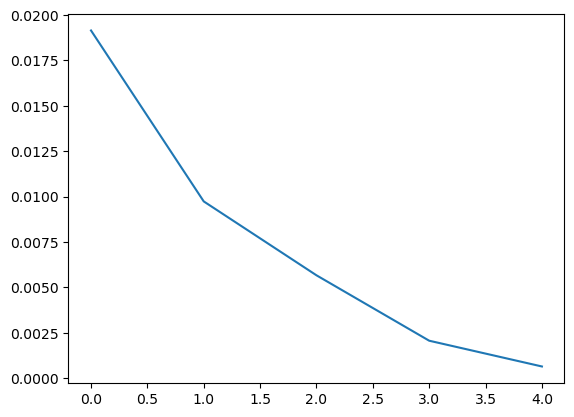

In [25]:
plt.plot(history.history['loss'])

In [26]:
test_x, test_y = seq2seq_model.truncate_single_step(test, window, features_in=range(1), features_out=range(1))
results = model.evaluate(test_x, test_y)
preds = model.predict(test_x)

56/56 [==============================] - 0s 3ms/step


(1770, 1)
RMSE:  0.1384319661349734
MAE:  0.09024808555841446


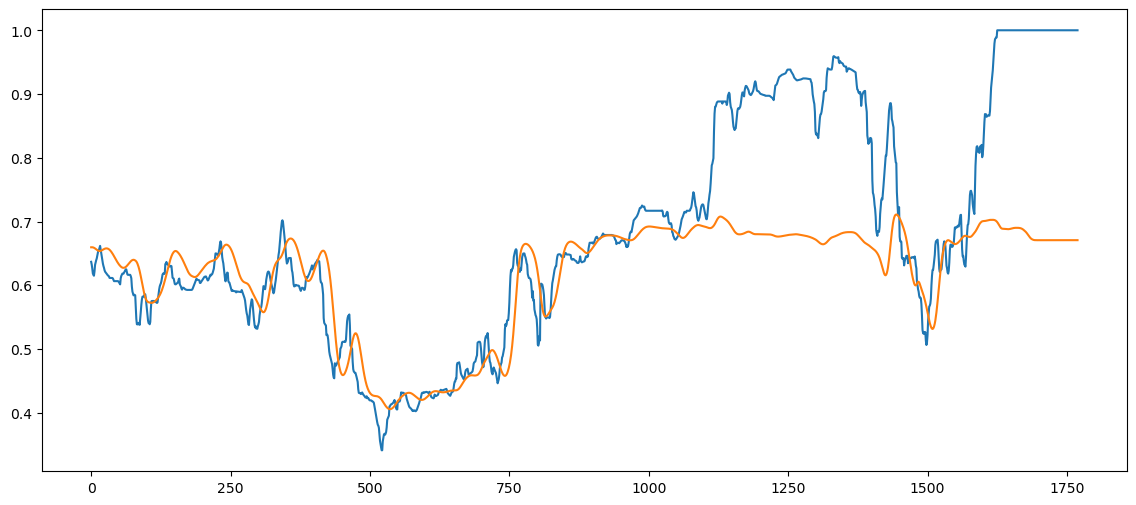

In [27]:
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
plt.plot(preds[:,0])
print(preds.shape)
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [ ]:
print('RMSE: ', results[0])
print('MAE: ', results[1])
forecasts_arr = np.array(forecasts)
forecasts_flat = forecasts_arr[:, :, 0, 0].flatten()
print(forecasts_arr.shape)
print(forecasts_flat.shape)
df_preds = pd.DataFrame({'Predictions': forecasts_flat}).shift(1)
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
i = 0
idx = 0

while idx + forecast_window <= test_x.shape[0]:
     idx = forecast_window * i + 1
     s_pred = df_preds.iloc[idx:idx + forecast_window]
     plt.plot(s_pred, '--', color='red')
     i += 1

In [ ]:
pred_length = test_y.shape[0]
print(df_preds['Predictions'].iloc[:pred_length:36])
df_scores = pd.DataFrame({'Forecasts': df_preds['Predictions'].iloc[:pred_length:36], 'Actual': test_y[1::36,0]})
df_scores['absolute error'] = abs(df_scores['Actual'] - df_scores['Forecasts'])
df_scores['squared error'] = df_scores['absolute error']**(2)
print('Mean absolute error of last forecast observation: ', df_scores['absolute error'].mean())
print('Mean squared error of last forecast observation: ', df_scores['squared error'].mean())
print('Root mean squared error of last forecast observation: ', np.sqrt(df_scores['squared error'].mean()))
plt.plot(df_scores['squared error'])

In [ ]:
# print('RMSE: ', score)
# actual_odds = actual.reshape((actual.shape[0]*actual.shape[1]))
# predicted_odds = predicted.reshape((predicted.shape[0]*predicted.shape[1]))
# df_pred = pd.DataFrame({'pred':predicted_odds})
# plt.figure(figsize=(14,6))
# plt.plot(actual_odds)
# for i in range(predicted.shape[0]):
#     idx = 60 * i
#     s_pred = df_pred.iloc[idx:idx + 60]
#     plt.plot(s_pred, '--', color='red')

In [ ]:
# plt.figure(figsize=(14,6))
# plt.plot(scores, '-o')